<a href="https://colab.research.google.com/github/VaggelisApostolou/auth-dws-ml-2025/blob/main/ML_Exercise10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# **Ερωτήματα**

## *Ερώτημα 1*

In [2]:
df = pd.read_csv('dataset.csv')
print(df)
print(df.describe())

        Unnamed: 0                track_id                 artists  \
0                0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1                1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2                2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3                3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4                4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   
...            ...                     ...                     ...   
113995      113995  2C3TZjDRiAzdyViavDJ217           Rainy Lullaby   
113996      113996  1hIz5L4IB9hN3WRYPOCGPw           Rainy Lullaby   
113997      113997  6x8ZfSoqDjuNa5SVP5QjvX           Cesária Evora   
113998      113998  2e6sXL2bYv4bSz6VTdnfLs        Michael W. Smith   
113999      113999  2hETkH7cOfqmz3LqZDHZf5           Cesária Evora   

                                               album_name  \
0                                                  Comedy   
1                                    

In [3]:
metadata_cols = ['number', 'track_id', 'artists', 'album_name', 'track_name']
existing_metadata = [col for col in metadata_cols if col in df.columns]
df_metadata = df[existing_metadata].copy()
df_features = df.drop(columns=existing_metadata)
df_features = pd.get_dummies(df_features, columns=['track_genre'])

## *Ερώτημα 2*

In [4]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)

## *Ερώτημα 3*

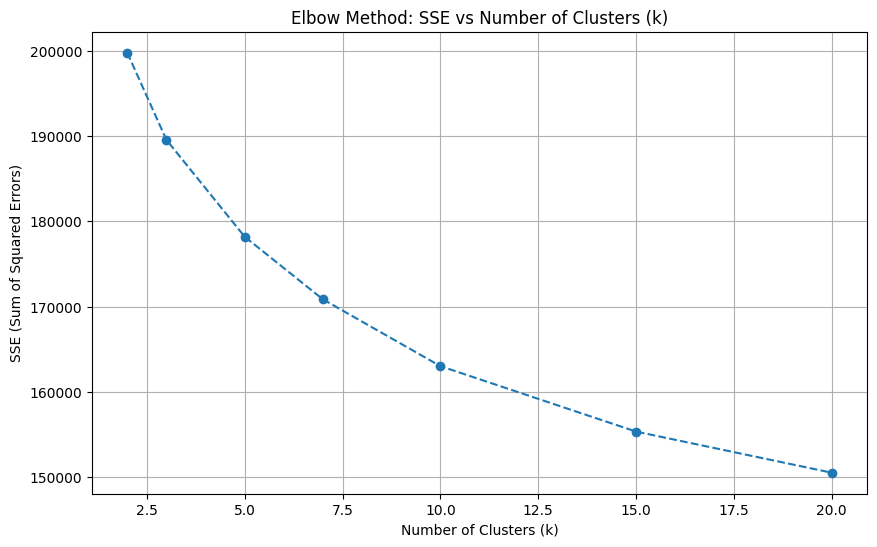

In [5]:
k_values = [2, 3, 5, 7, 10, 15, 20]
sse = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o', linestyle='--')
plt.title('Elbow Method: SSE vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.grid(True)
plt.show()

## *Ερώτημα 4*

In [6]:
best_k = 5
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(df_scaled)
df_metadata['Cluster'] = cluster_labels
df_features['Cluster'] = cluster_labels

## *Ερώτημα 5*


Ανάλυση Κυρίαρχων Ειδών:
         Cluster Dominant Genre  Percentage
Cluster                                    
0              0         comedy    6.753140
1              1      power-pop    1.632460
2              2  drum-and-bass    1.826759
3              3     honky-tonk    3.759828
4              4        romance    6.893118


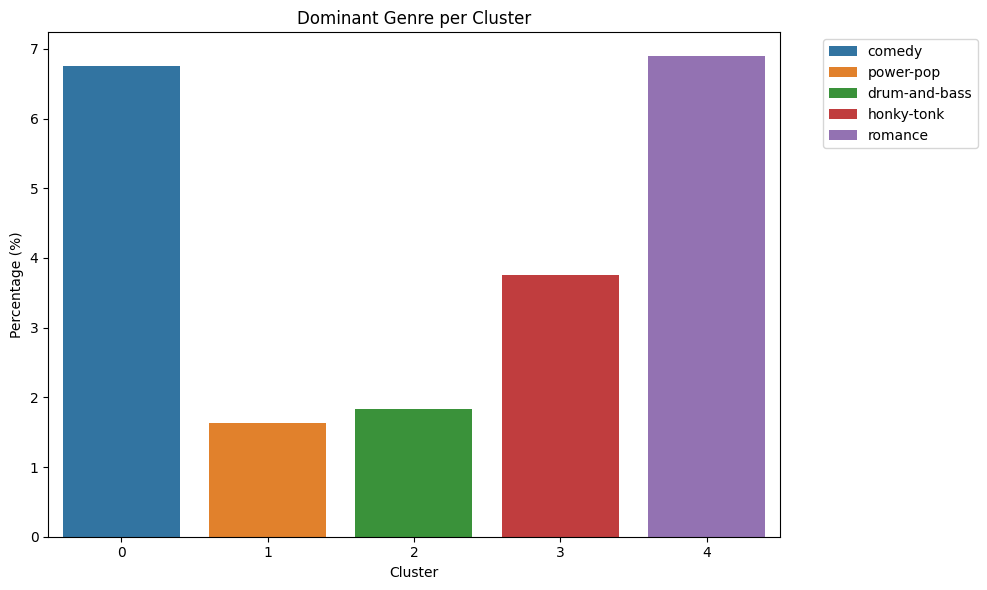

In [7]:
df['Cluster'] = kmeans.labels_
target_col = "track_genre"
cross_tab = pd.crosstab(df['Cluster'], df[target_col])
dominant_genres = cross_tab.idxmax(axis=1)
max_counts = cross_tab.max(axis=1)
total_counts = cross_tab.sum(axis=1)
percentages = (max_counts / total_counts) * 100
df_dominance = pd.DataFrame({
  'Cluster': cross_tab.index,
  'Dominant Genre': dominant_genres,
  'Percentage': percentages
})
print("\nΑνάλυση Κυρίαρχων Ειδών:")
print(df_dominance)
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Percentage', data=df_dominance, hue='Dominant Genre', dodge=False)
plt.title('Dominant Genre per Cluster')
plt.ylabel('Percentage (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## *Ερώτημα 6*

In [8]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
my_song_title = "Highway to Hell"

def get_recommendations(song_title, data_meta, data_numeric, metric='euclidean'):
    song_row = data_meta[data_meta['track_name'] == song_title]
    if song_row.empty:
        return None, f"Το τραγούδι '{song_title}' δεν βρέθηκε στα δεδομένα."
    song_index = song_row.index[0]
    if 'Cluster' in data_meta.columns:
        song_cluster = song_row['Cluster'].values[0]
    else:
        song_cluster = df.loc[song_index, 'Cluster']
    cluster_indices = df[df['Cluster'] == song_cluster].index
    cols_to_drop = ['Cluster'] if 'Cluster' in data_numeric.columns else []
    cluster_features = data_numeric.drop(columns=cols_to_drop, errors='ignore').loc[cluster_indices]
    target_features = data_numeric.drop(columns=cols_to_drop, errors='ignore').loc[song_index].values.reshape(1, -1)
    if metric == 'euclidean':
        dists = euclidean_distances(target_features, cluster_features)
    elif metric == 'cosine':
        dists = cosine_distances(target_features, cluster_features)
    results_df = pd.DataFrame({
        'Index': cluster_indices,
        'Distance': dists[0]
    })
    recommendations = results_df[results_df['Index'] != song_index].sort_values(by='Distance').head(3)
    top_songs = data_meta.loc[recommendations['Index']]
    top_songs['Distance'] = recommendations['Distance'].values

    return top_songs[['track_name', 'artists', 'Distance']], None

In [9]:
print(f"Προτάσεις με βάση την Ευκλείδεια Απόσταση")
print(f"Τραγούδι Επιλογής: {my_song_title}")
recs_euclidean, error = get_recommendations(my_song_title, df, df_scaled, metric='euclidean')
if error:
    print(error)
else:
    print(recs_euclidean)
    print("\nΣχόλιο: Τα τραγούδια αυτά έχουν την μικρότερη 'γεωμετρική' απόσταση.")

Προτάσεις με βάση την Ευκλείδεια Απόσταση
Τραγούδι Επιλογής: Highway to Hell
                            track_name       artists  Distance
47012                    Enter Sandman     Metallica  0.270634
47667  You've Got Another Thing Coming  Judas Priest  0.278778
47050              The Final Countdown        Europe  0.290142

Σχόλιο: Τα τραγούδια αυτά έχουν την μικρότερη 'γεωμετρική' απόσταση.


## *Ερώτημα 7*

In [10]:
print(f"Προτάσεις με βάση την Cosine Distance")
recs_cosine, error = get_recommendations(my_song_title, df, df_scaled, metric='cosine')

if error:
    print(error)
else:
    print(recs_cosine)
    print("\nΣχόλιο: Η Cosine Distance εστιάζει περισσότερο στο 'προφίλ' του τραγουδιού παρά στην ένταση των τιμών.")

Προτάσεις με βάση την Cosine Distance
                            track_name       artists  Distance
47012                    Enter Sandman     Metallica  0.007119
47667  You've Got Another Thing Coming  Judas Priest  0.007161
47050              The Final Countdown        Europe  0.007202

Σχόλιο: Η Cosine Distance εστιάζει περισσότερο στο 'προφίλ' του τραγουδιού παρά στην ένταση των τιμών.


## *Ερώτημα 8*

In [11]:
from sklearn.metrics import silhouette_score
print(f"Έλεγχος ποιότητας clustering (Silhouette Score)")
score = silhouette_score(df_scaled, kmeans.labels_)
print(f"Silhouette Score για k={best_k}: {score:.3f}")
# Ερμηνεία:
# > 0.5: Πολύ καλό
# 0.25 - 0.5: Ικανοποιητικό (συχνό σε δεδομένα μουσικής)
# < 0.25: Οι ομάδες μπλέκονται αρκετά

Έλεγχος ποιότητας clustering (Silhouette Score)
Silhouette Score για k=5: 0.091


## *Ερώτημα 9*

In [12]:
from sklearn.cluster import DBSCAN
import numpy as np
X_dbscan = df_scaled.drop(columns=['Cluster'], errors='ignore')
eps_values_to_test = [0.3, 0.5, 0.6, 0.8]
min_samples_val = 5
best_dbscan_labels = None
best_n_clusters = 0
for eps_val in eps_values_to_test:
    dbscan = DBSCAN(eps=eps_val, min_samples=min_samples_val)
    labels = dbscan.fit_predict(X_dbscan)
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print(f"Για eps={eps_val}: Βρέθηκαν {n_clusters_} clusters και {n_noise_} σημεία θορύβου.")
    if n_clusters_ > 1 and best_dbscan_labels is None:
        best_dbscan_labels = labels
        best_n_clusters = n_clusters_

print("\nΣύγκριση")
if best_n_clusters > 0:
    print(f"O K-Means πρότεινε {best_k} ομάδες.")
    print(f"O DBSCAN (με βέλτιστο eps) βρήκε {best_n_clusters} ομάδες.")

    if best_n_clusters < best_k:
        print("Συμπέρασμα: Ο DBSCAN βρήκε λιγότερες ομάδες, θεωρώντας πιθανώς πολλά τραγούδια ως θόρυβο.")
    elif best_n_clusters > best_k:
        print("Συμπέρασμα: Ο DBSCAN βρήκε περισσότερες, μικρότερες πυκνότητες τραγουδιών.")
    else:
        print("Συμπέρασμα: Οι αλγόριθμοι συμφωνούν στον αριθμό των ομάδων!")
else:
    print("O DBSCAN δεν κατάφερε να βρει διακριτές ομάδες με τις παραμέτρους που δοκιμάστηκαν.")
    print("Όλα τα δεδομένα θεωρήθηκαν είτε θόρυβος, είτε μία ενιαία μάζα.")

Για eps=0.3: Βρέθηκαν 1406 clusters και 47307 σημεία θορύβου.
Για eps=0.5: Βρέθηκαν 483 clusters και 5025 σημεία θορύβου.
Για eps=0.6: Βρέθηκαν 419 clusters και 1745 σημεία θορύβου.
Για eps=0.8: Βρέθηκαν 389 clusters και 284 σημεία θορύβου.

Σύγκριση
O K-Means πρότεινε 5 ομάδες.
O DBSCAN (με βέλτιστο eps) βρήκε 1406 ομάδες.
Συμπέρασμα: Ο DBSCAN βρήκε περισσότερες, μικρότερες πυκνότητες τραγουδιών.
